In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pickle
import paperfig as pf

In [5]:
def likelihood(params):
    pass

<>:173: SyntaxWarning: invalid escape sequence '\m'
<>:173: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_5913/834221430.py:173: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Wavelength ($\mu$m)")


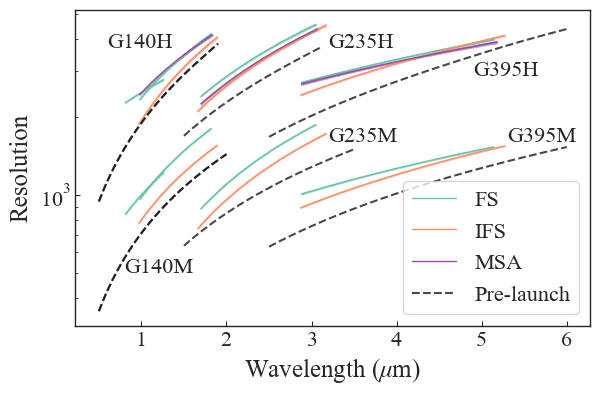

In [ ]:
# plot the best fit line
pf.set_fontscale(2)

dispersers = ["G140", "G140", "G235", "G395"]
filters = ["F070LP", "F100LP", "F170LP", "F290LP"]

colors = [pf.cb2_emerald, pf.cb2_orange, pf.cb_purple]

fig, ax = plt.subplots(figsize=pf.get_fig_size(width=pf.mnras_colwidth * 2))

for disperser, filter in zip(dispersers, filters):
    for n, mode in enumerate(["FS", "IFS", "MSA"]):
        color = colors[n]
        for j in range(2):
            if j == 0 and mode == "MSA":
                continue

            if mode == "MSA" or mode == "IFS":
                if filter == "F070LP":
                    continue

            res_string = ["M", "H"][j]

            # Load the data
            with open(
                f"samplers/sampler_{disperser.upper()}_{filter.upper()}_{mode.upper()}.pkl",
                "rb",
            ) as f:
                output = pickle.load(f)
                points = output["points"]
                log_w = output["log_w"]
                lambda_pivot = output["lambda_pivot"]
                nonzero_wavelengths = output["wavelengths"]

            def get_resolution(ls, coeffs):
                r = 0.0

                for i, c in enumerate(coeffs):
                    r += c * ((np.array(ls) - lambda_pivot) / 1.0e4) ** i

                return r

            def get_sigma_inst(ls, coeffs):
                s = 1

                for i in range(1, len(coeffs)):
                    s += coeffs[i] * ((np.array(ls) - lambda_pivot) / 1.0e4) ** i

                return coeffs[0] / s

            pn_sigma_mean = 6.90
            pn_sigma_std = 0.49

            best_fit_params = points[np.argmax(log_w)]

            mid_res_params = best_fit_params[1:3]
            hi_res_params = best_fit_params[4:6]

            best_fit_params_both = [mid_res_params, hi_res_params]

            N = 1000
            resolution_samples = np.zeros((N, len(nonzero_wavelengths)))
            for i in range(N):
                coeffs = points[
                    np.random.choice(
                        len(points), p=np.exp(log_w) / np.sum(np.exp(log_w))
                    )
                ]
                if j == 0:
                    coeff = coeffs[1:3]
                else:
                    coeff = coeffs[4:6]

                sigma_inst = get_sigma_inst(
                    nonzero_wavelengths,
                    coeff,
                )
                sigma_inst = np.sqrt(
                    sigma_inst**2
                    - np.random.normal(
                        pn_sigma_mean, pn_sigma_std, size=len(sigma_inst)
                    )
                    ** 2
                )
                light_speed = 2.99792458e5
                resolution_samples[i] = light_speed / sigma_inst / 2.355

            ax.plot(
                nonzero_wavelengths / 1e4,
                np.median(resolution_samples, axis=0),
                color=color,
                label=f"{mode.upper()}",
                lw=1,
            )

            ax.fill_between(
                nonzero_wavelengths / 1e4,
                np.percentile(resolution_samples, 16, axis=0),
                np.percentile(resolution_samples, 84, axis=0),
                color=color,
                alpha=0.5,
            )

    for j in range(2):
        res_string = ["M", "H"][j]
        nominal = fits.getdata(
            f"data/jwst/jwst_nirspec_{disperser}{res_string}_disp.fits"
        )

        nominal = np.array([tuple(row) for row in nominal])

        # Extract the wavelength and sensitivity values
        nominal_wavelength = nominal[:, 0] * 1e4
        nominal_resolution = nominal[:, 2]

        ax.plot(
            nominal_wavelength / 1e4,
            nominal_resolution,
            color="k",
            linestyle="--",
            label="Pre-launch",
            alpha=0.8,
        )


# only show a single legend for each legends
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    [handles[i] for i in [0, 6, 8, 2]],
    [labels[i] for i in [0, 6, 8, 2]],
    loc="lower right",
    fontsize=pf.mnras_figcaption_fontsize * 2,
)

ax.text(8000 / 1e4, 500, "G140M", fontsize=pf.mnras_figcaption_fontsize * 2)
ax.text(6000 / 1e4, 3700, "G140H", fontsize=pf.mnras_figcaption_fontsize * 2)
ax.text(32000 / 1e4, 1600, "G235M", fontsize=pf.mnras_figcaption_fontsize * 2)
ax.text(32000 / 1e4, 3700, "G235H", fontsize=pf.mnras_figcaption_fontsize * 2)
ax.text(53000 / 1e4, 1600, "G395M", fontsize=pf.mnras_figcaption_fontsize * 2)
ax.text(49000 / 1e4, 2900, "G395H", fontsize=pf.mnras_figcaption_fontsize * 2)

# plt.grid()
# plt.xlim(10000, 20000)
# plt.ylim(0, 4000)
ax.set_xlabel("Wavelength ($\mu$m)")
ax.set_ylabel("Resolution")
ax.set_yscale("log")

# plt.title(f"NIRSpec {disperser.upper()} Resolution")

fig.savefig(
    "/Users/ajshajib/Dropbox/papers_proposals/jwst_lsf/f3.pdf", bbox_inches="tight"
)

In [ ]:
from IPython.display import Markdown


def get_two_sig_figs(x):
    if round(x) < 10:
        return f"0{x:.0f}"
    else:
        return f"{x:.0f}"


# Prepare the data for the table
table_data = []
for n, mode in enumerate(["FS", "IFS", "MSA"]):
    table_data.append(
        [
            f"\\textbf{{{mode.upper()} mode}}",
            "",
            "",
            "",
            "",
        ]
    )
    for disperser, filter in zip(dispersers, filters):
        if mode == "IFS" or mode == "MSA":
            if filter == "F070LP":
                continue
        with open(
            f"samplers/sampler_{disperser.upper()}_{filter.upper()}_{mode}.pkl",
            "rb",
        ) as f:
            output = pickle.load(f)
            points = output["points"]
            log_w = output["log_w"]
            lambda_pivot = output["lambda_pivot"]
            nonzero_wavelengths = output["wavelengths"]

        # best_fit_params = points[np.argmax(log_w)]
        weights = np.exp(log_w - np.max(log_w))
        weights /= np.sum(weights)

        pivot_wavelength = lambda_pivot

        for res_index, res_params in enumerate(best_fit_params_both):
            if res_index == 0 and mode == "MSA":
                continue
            velocity, velocity_hi, velocity_low = np.percentile(
                points[:, res_index * 3],
                [50, 84, 16],
                method="inverted_cdf",
                weights=weights,
                axis=0,
            )
            velocity_uncertainty = np.mean(
                [
                    velocity_hi - velocity,
                    velocity - velocity_low,
                ]
            )

            sigma_inst, sigma_inst_hi, sigma_inst_low = np.percentile(
                points[:, res_index * 3 + 1],
                [50, 84, 16],
                method="inverted_cdf",
                weights=weights,
                axis=0,
            )
            sigma_inst_uncertainty = np.mean(
                [
                    sigma_inst_hi - sigma_inst,
                    sigma_inst - sigma_inst_low,
                ]
            )

            alpha, alpha_hi, alpha_low = np.percentile(
                points[:, res_index * 3 + 2],
                [50, 84, 16],
                method="inverted_cdf",
                weights=weights,
                axis=0,
            )
            alpha_uncertainty = np.mean(
                [
                    alpha_hi - alpha,
                    alpha - alpha_low,
                ]
            )
            prefix = "" if sigma_inst >= 100 else f"\\phantom{{0}}"
            table_data.append(
                [
                    disperser + ["M", "H"][res_index],
                    filter,
                    f"{pivot_wavelength:.2f}",
                    # f"${velocity:.2f} \\pm {velocity_uncertainty:.2f}$",
                    f"${prefix}{sigma_inst:.2f}\,({get_two_sig_figs(sigma_inst_uncertainty*100)})$",
                    f"${alpha:.4f}\,({get_two_sig_figs(alpha_uncertainty*10000)})$",
                ]
            )

# Generate the LaTeX table
latex_table = """\\begin{table*}\n\\caption{\\label{tab:param_values}   
    Best-fit values for parameters in the expression of $\sigma_{\\rm inst}^\prime(\lambda)$ in Eq.~(\\ref{eq:parametrization}).}
    \\renewcommand{\\arraystretch}{1}\n\\centering\n\\begin{tabular}{lcccc}\n\\hline\\hline\n"""
latex_table += "Disperser & Filter & $\\lambda_{\\rm piv}$ ($\\AA$) & $\sigma^\prime_{\\rm piv}$ (km s$^{-1}$) & $\\alpha$ \\\\\n\\hline\n"
for row in table_data:
    latex_table += f"{row[0]} & {row[1]} & {row[2]} & {row[3]} & {row[4]} \\\\ \n"
latex_table += "\\hline\n\\end{tabular}\n\\end{table*}"

# Display the LaTeX table
display(Markdown(f"```latex\n{latex_table}\n```"))

<>:94: SyntaxWarning: invalid escape sequence '\,'
<>:95: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
<>:94: SyntaxWarning: invalid escape sequence '\,'
<>:95: SyntaxWarning: invalid escape sequence '\,'
<>:100: SyntaxWarning: invalid escape sequence '\s'
<>:103: SyntaxWarning: invalid escape sequence '\s'
/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_5913/2817885987.py:94: SyntaxWarning: invalid escape sequence '\,'
  f"${prefix}{sigma_inst:.2f}\,({get_two_sig_figs(sigma_inst_uncertainty*100)})$",
/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_5913/2817885987.py:95: SyntaxWarning: invalid escape sequence '\,'
  f"${alpha:.4f}\,({get_two_sig_figs(alpha_uncertainty*10000)})$",
/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_5913/2817885987.py:100: SyntaxWarning: invalid escape sequence '\s'
  latex_table = """\\begin{table*}\n\\caption{\\label{tab:p

```latex
\begin{table*}
\caption{\label{tab:param_values}   
    Best-fit values for parameters in the expression of $\sigma_{\rm inst}^\prime(\lambda)$ in Eq.~(\ref{eq:parametrization}).}
    \renewcommand{\arraystretch}{1}
\centering
\begin{tabular}{lcccc}
\hline\hline
Disperser & Filter & $\lambda_{\rm piv}$ ($\AA$) & $\sigma^\prime_{\rm piv}$ (km s$^{-1}$) & $\alpha$ \\
\hline
\textbf{FS mode} &  &  &  &  \\ 
G140M & F070LP & 10111.02 & $126.08\,(05)$ & $0.8313\,(45)$ \\ 
G140H & F070LP & 10111.02 & $\phantom{0}51.41\,(03)$ & $0.4487\,(76)$ \\ 
G140M & F100LP & 13347.24 & $\phantom{0}96.94\,(08)$ & $0.7540\,(27)$ \\ 
G140H & F100LP & 13347.24 & $\phantom{0}41.62\,(03)$ & $0.6857\,(31)$ \\ 
G235M & F170LP & 22765.89 & $\phantom{0}97.92\,(03)$ & $0.5543\,(09)$ \\ 
G235H & F170LP & 22765.89 & $\phantom{0}39.19\,(02)$ & $0.4635\,(17)$ \\ 
G395M & F290LP & 38474.54 & $103.62\,(07)$ & $0.1872\,(21)$ \\ 
G395H & F290LP & 38474.54 & $\phantom{0}39.80\,(04)$ & $0.1667\,(34)$ \\ 
\textbf{IFS mode} &  &  &  &  \\ 
G140M & F100LP & 13539.59 & $115.80\,(02)$ & $0.7622\,(04)$ \\ 
G140H & F100LP & 13539.59 & $\phantom{0}46.50\,(01)$ & $0.8331\,(07)$ \\ 
G235M & F170LP & 22938.52 & $110.75\,(02)$ & $0.5627\,(04)$ \\ 
G235H & F170LP & 22938.52 & $\phantom{0}41.70\,(03)$ & $0.4988\,(17)$ \\ 
G395M & F290LP & 38891.71 & $109.09\,(02)$ & $0.2317\,(02)$ \\ 
G395H & F290LP & 38891.71 & $\phantom{0}41.17\,(02)$ & $0.2178\,(11)$ \\ 
\textbf{MSA mode} &  &  &  &  \\ 
G140H & F100LP & 13398.32 & $\phantom{0}40.97\,(06)$ & $0.6132\,(56)$ \\ 
G235H & F170LP & 22851.78 & $\phantom{0}41.15\,(07)$ & $0.4775\,(55)$ \\ 
G395H & F290LP & 38621.43 & $\phantom{0}40.48\,(14)$ & $0.1594\,(62)$ \\ 
\hline
\end{tabular}
\end{table*}
```